In [34]:
# https://www.cs.toronto.edu/~kriz/cifar.html
# !wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

In [35]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def imshow(img):
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

In [36]:
files = unpickle('./data/data_batch_1')
files.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [37]:
data = files[b'data']
labels = files[b'labels']

In [38]:
data.shape

(10000, 3072)

In [39]:
data = data.reshape(10000, 3, 32, 32)
data.shape

(10000, 3, 32, 32)

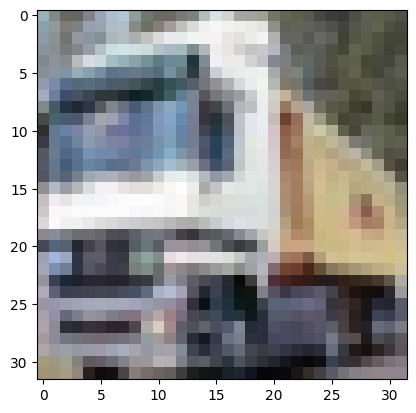

In [40]:
imshow(data[1])

In [41]:
labels[1]

9

In [42]:
classes[labels[1]]

'truck'

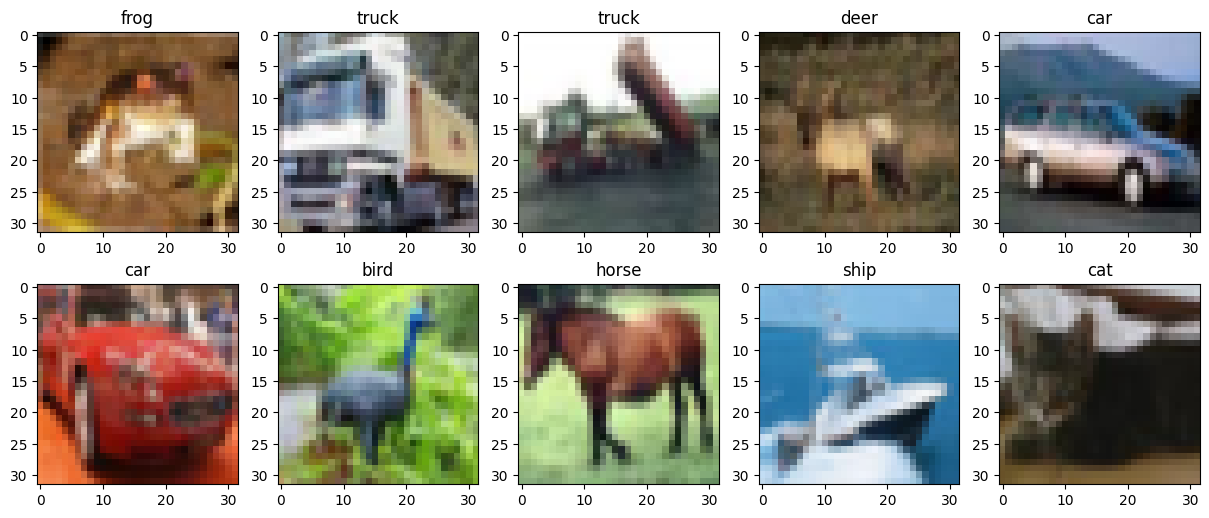

In [43]:
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
idx=0
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(data[idx].transpose(1, 2, 0))
        ax[i, j].set_title(classes[labels[idx]])
        idx += 1

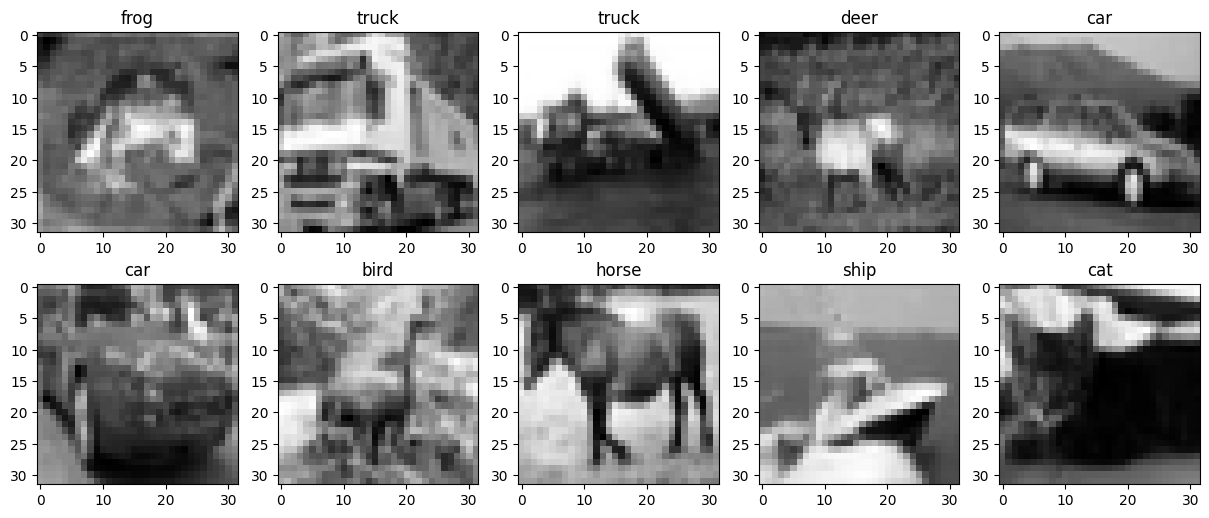

In [44]:
# convert to grayscale
data_gray = np.mean(data, axis=1)
data_gray.shape

idx = 0
fig, ax = plt.subplots(2, 5, figsize=(15, 6))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(data_gray[idx], cmap='gray')
        ax[i, j].set_title(classes[labels[idx]])
        idx += 1

In [45]:
#convert to dataframe
import pandas as pd
data = pd.DataFrame(data_gray.reshape(10000, 1024))

In [46]:
first_image = data.iloc[0]
np_image = first_image.values
np_image = np_image.reshape(32,32)

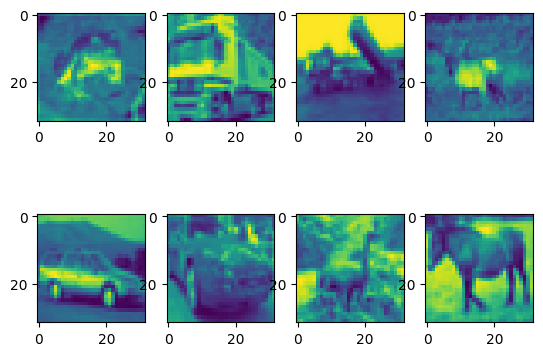

In [47]:
fig, ax = plt.subplots(2,4)

ax[0,0].imshow(data.iloc[0].values.reshape(32,32))
ax[0,1].imshow(data.iloc[1].values.reshape(32,32))
ax[0,2].imshow(data.iloc[2].values.reshape(32,32))
ax[0,3].imshow(data.iloc[3].values.reshape(32,32))
ax[1,0].imshow(data.iloc[4].values.reshape(32,32))
ax[1,1].imshow(data.iloc[5].values.reshape(32,32))
ax[1,2].imshow(data.iloc[6].values.reshape(32,32))
ax[1,3].imshow(data.iloc[7].values.reshape(32,32))

In [53]:
#split data into train and test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

#convert to tensors with float datatype

X_train = torch.tensor(X_train.values).float()
X_test = torch.tensor(X_test.values).float()
y_train = torch.tensor(y_train).float()
y_test = torch.tensor(y_test).float()


In [54]:
class MySimpleNN(torch.nn.Module):   # MySimpleNN erbt von torch.nn.Module

     # Konstruktor
    def __init__(self, input_size=1024, hidden_size=(10, 20, 10), output_size=1):
        # Aufruf des Superkonstruktors von torch.nn.Module
        super(MySimpleNN, self).__init__()
        # Definition der Schichten

        # fc1 --> fully connected layer 1 von 12 auf 70 Neuronen
        # warum 12? --> 12 Features
        self.fc1 = torch.nn.Linear(input_size, hidden_size[0])
        # fc2 --> fully connected layer 2 von 70 auf 120 Neuronen
        self.fc2 = torch.nn.Linear(hidden_size[0], hidden_size[1])
        # fc3 --> fully connected layer 3 von 120 auf 30 Neuronen
        self.fc3 = torch.nn.Linear(hidden_size[1], hidden_size[2])
        # fc4 --> fully connected layer 4 von 30 auf 1 Neuronen
        # Warum 1 Neuron? --> 1 Output, wir lesen da den Alkoholgehahlt aus
        self.fc4 = torch.nn.Linear(hidden_size[2], output_size)

        # Batch Normalization
        # 70, 120, 30 sind die Anzahl der Neuronen in den Schichten
        self.bn1 = torch.nn.BatchNorm1d(hidden_size[0])
        self.bn2 = torch.nn.BatchNorm1d(hidden_size[1])
        self.bn3 = torch.nn.BatchNorm1d(hidden_size[2])

         # forward Methode -> Forward Propagation
    # wenn ich später ein Objekt von MySimpleNN erzeuge, dann kann ich
    # dieses Objekt mit einem Tensor aufrufen, dann wird die forward Methode
    # aufgerufen. z.B. model(x_train)
    def forward(self, xb):   # xb steht für eine Batch von X-Werten
        #print("xb", xb.shape)
        z2 = self.fc1(xb)  # dahinter steckt x@w1 + b1
        a2 = torch.relu(z2)    # alle negativen Werte werden auf 0 gesetzt, der Rest bleibt
        #print("a2", a2.shape)
        a2_bn = self.bn1(a2) # Normalisierung der Werte auf den Neuronen
        #print("a2_bn", a2_bn.shape)
        z3 = self.fc2(a2_bn) # dahinter steckt a2@w2 + b2
        #print("z3", z3.shape)
        a3 = torch.relu(z3)
        #print("a3", a3.shape)
        a3_bn = self.bn2(a3)
        #print("a3_bn", a3_bn.shape)
        z4 = self.fc3(a3_bn)
        #print("z4", z4.shape)
        a4 = torch.relu(z4)
        #print("a4", a4.shape)
        a4_bn = self.bn3(a4)
        #print("a4_bn", a4_bn.shape)
        y_hat = torch.relu(self.fc4(a4_bn))
        #print("y_hat", y_hat.shape)
        return y_hat

In [50]:
def get_batch(x, y, batch_size):
    for i in range(0, len(x), batch_size):
        # yield: gibt den Wert zurück, aber merkt sich den aktuellen Zustand
        yield x[i:i+batch_size], y[i:i+batch_size]

In [56]:
xb , yb = next(get_batch(X_train, y_train, 10))
model = MySimpleNN()
print(model(xb))

tensor([[0.0000],
        [0.0000],
        [0.0000],
        [0.2465],
        [1.6527],
        [0.5341],
        [0.0000],
        [0.0385],
        [0.0000],
        [0.0000]], grad_fn=<ReluBackward0>)


In [ ]:
# eigenes Modell wird erstellt
model = MySimpleNN()
lr=0.0001
# trainiere immer mit 256 Datensätzen auf einmal
batch_size=256

# loss function
# Mean Squared Error
# die Lossfunction von Pytorch müssen erstmal erstellt werden mit ()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=10)

def train(xb, yb):
    y_hat=model(xb)
    loss = loss_fn(y_hat, yb)
    loss.backward()
    optimizer.step()
    return loss.item()

losses=[]
# import tqdm notebook
for epoch in (range(100)):
    loss_sum=0
    # Iteration über alle Batches
    for xb, yb in get_batch(X_train, y_train, batch_size):
        loss_sum += train(xb, yb)
    loss_epoch = loss_sum/len(X_train)
    losses.append(loss_sum/len(X_train))
    scheduler.step(loss_epoch)
    if epoch % 10 == 0:
        print("Epoch: ", epoch, "Loss: ", loss_epoch, "LR: ", optimizer.param_groups[0]['lr'])

#plot
import matplotlib.pyplot as plt
plt.plot(losses)